# Updated downsampling; removing group=7 (flawed) SWS spectra

Specifically, was accidentally training NN on full dataset (!) instead of just training set. Oops.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace as st
from sklearn.model_selection import train_test_split

print(tf.__version__)

1.10.0


## Dataset: ISO-SWS

In [2]:
# Needed directories
base_dir = '../data/isosws_atlas/'

# Pickles containing our spectra in the form of pandas dataframes:
spec_dir = base_dir + 'spectra/'
spec_files = np.sort(glob.glob(spec_dir + '*.pkl'))

# Metadata pickle (pd.dataframe). Note each entry contains a pointer to the corresponding spectrum pickle.
metadata = base_dir + 'metadata.pkl'

In [3]:
# Load the metadata pickle.
meta = pd.read_pickle(metadata)

In [4]:
# meta

### Remove entries in dataframe where group = 7 (fatally flawed)

In [5]:
meta_clean = meta.query('group != "7"')

In [6]:
meta_clean.describe()

,ra,dec
count,1058.000000,1058.000000
mean,229.948241,6.363673
std,100.353651,42.686995
min,0.532083,-79.646694
25%,182.316469,-28.996035
50%,268.232292,8.755458
75%,300.364833,46.367757
max,359.603292,89.264111


### Labels

In [8]:
# Simple classifier first.
labels = meta_clean['group'].values.astype(int)

In [9]:
# The possible labels.
np.unique(labels)

array([1, 2, 3, 4, 5, 6])

In [10]:
# SHIFTING TO START AT ZERO!
labels = labels - 1

#### Labels ('group'):

1. Naked stars
2. Stars with dust
3. Warm, dusty objects
4. Cool, dusty objects
5. Very red objects
6. Continuum-free objects but having emission lines
7. Flux-free and/or fatally flawed spectra

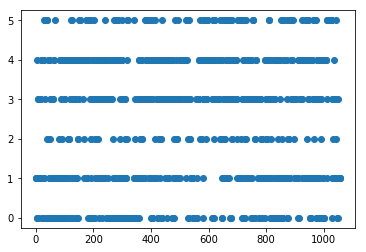

In [11]:
# See how the labels are distributed.
plt.plot(labels, 'o');

In [12]:
type(labels[0]), len(labels)

(numpy.int64, 1058)

In [13]:
# Make sure each sample has a valid label.
np.sum(np.isfinite(labels)) == len(labels)

True

In [14]:
# knowing that each sample has a 359-point vector/spectrum.
features = np.zeros((len(labels), 359))

### Features

In [15]:
def load_spectrum(path):
    df = pd.read_pickle(path)
    flux = df['flux']
    return flux / np.nanmax(flux)

index = 0
# Fill the 'spectra' variable with the astronomical data.
for row in meta_clean.itertuples(index=True, name='Pandas'):
    flux = load_spectrum(base_dir + row.file_path)
    features[index] = flux
    index += 1

In [16]:
features.shape

(1058, 359)

# Split into training and test sets

Data as...
- features (1058, 359)
- labels (1058)

In [17]:
X_train, X_test, y_train, y_test = \
train_test_split(features, labels, test_size=0.40, random_state = 22)

In [18]:
X_train.shape

(634, 359)

In [19]:
X_test.shape

(424, 359)

In [20]:
y_train.shape

(634,)

In [21]:
y_test.shape

(424,)

# Extra optional scaling

In [22]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1. Neural network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                23040     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 455       
Total params: 35,975
Trainable params: 35,975
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.5390061364983613
Test accuracy: 0.8231132075471698


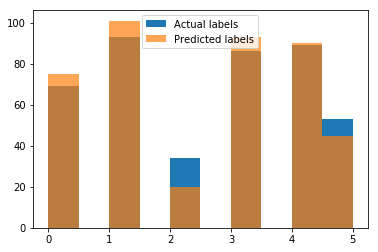

In [35]:
# Sequential model, 7 classes of output.
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_dim=359))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(7, activation='softmax'))

# Early stopping condition.
callback = [tf.keras.callbacks.EarlyStopping(monitor='acc', patience=4, verbose=0)]

# Recompile model and fit.
model.compile(optimizer=tf.train.AdamOptimizer(0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=500, batch_size=32, callbacks=callback, verbose=False)

# Summary
model.summary()

# Check accuracy.
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Check predictions.
predictions = model.predict(X_test)
predicted_groups = [np.argmax(x) for x in predictions]
plt.hist(y_test, label='Actual labels');
plt.hist(predicted_groups, label='Predicted labels', alpha=0.7);
plt.legend(loc=0);

# Model 2. k-nearest neighbours (KNN)

http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#nearest-neighbor-and-the-curse-of-dimensionality

In [24]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

In [25]:
knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [26]:
predicted_labels = knn.predict(X_test_scaled)
test_acc = np.sum(predicted_labels == y_test) / len(y_test)
print('Test accuracy:', test_acc)

Test accuracy: 0.7476415094339622


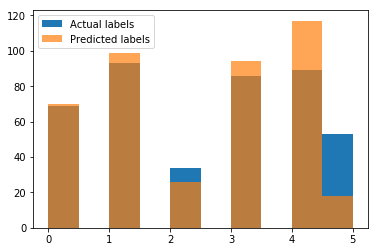

In [27]:
plt.hist(y_test, label='Actual labels');
plt.hist(predicted_labels, label='Predicted labels', alpha=0.7);
plt.legend(loc=0);

# Model 3. Logistic regression

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [28]:
from sklearn import linear_model

In [36]:
logistic = linear_model.LogisticRegression()
# logrun = logistic.fit(X_train, y_train)
logrun = logistic.fit(X_train_scaled, y_train)

In [30]:
predicted_labels = logrun.predict(X_test_scaled)
test_acc = np.sum(predicted_labels == y_test) / len(y_test)
print('Test accuracy:', test_acc)

Test accuracy: 0.7995283018867925


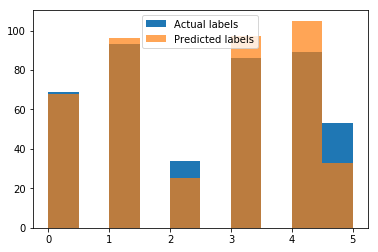

In [31]:
plt.hist(y_test, label='Actual labels');
plt.hist(predicted_labels, label='Predicted labels', alpha=0.7);
plt.legend(loc=0);